In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
from datetime import datetime
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [3]:
df_jhu = pd.read_csv(f"{homedir}/data/us/aggregate_jhu.csv")
df_berk = pd.read_csv(f"{homedir}/data/us/aggregate_berkeley.csv")

In [4]:
# Get rid of the aggregate country data
df_jhu = df_jhu.drop([0])
df_jhu['FIPS'] = df_jhu['FIPS'].map(lambda f : str(f))

In [5]:
def alter(fips):
    if len(fips) == 4:
        return '0' + fips
    return fips
df_jhu['FIPS'] = df_jhu['FIPS'].map(alter)
df_jhu = df_jhu.set_index('FIPS')
df_jhu['fips'] = df_jhu.index.map(lambda s : int(s))

In [13]:
# gets list of all fips numbers
def get_fips():
    Y = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
    return set(Y.fips.values)

def get_date(datestr, formatstr='%Y-%m-%d'):
    return datetime.strptime(datestr, formatstr)

In [66]:
cum_deaths = pd.read_csv(f"{homedir}/data/us/covid/deaths.csv")
cum_deaths = cum_deaths.iloc[1:]
def get_cum_deaths(fips):
    idx = cum_deaths.index[cum_deaths['countyFIPS'] == fips].values[0]
    county_deaths = cum_deaths.loc[cum_deaths['countyFIPS'] == fips]
    county_deaths
    dates = pd.to_datetime(county_deaths.columns[4:].values).map(lambda dt : str(dt))
    X = np.array([(get_date(d[:10]) - get_date('2020-01-01')).days for d in dates])
    y = []
    county_deaths.head()
    for i in range(4, len(county_deaths.columns)):
        y.append(county_deaths.loc[idx,county_deaths.columns[i]])
    return X, y

In [130]:
NYT_counties_daily = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
# Gets the number of deaths per day of a given county along with the time, counted in days
# since Jan 1st
def get_delta_deaths(fips, clip_zeros=True):
    Y_county = NYT_counties_daily.loc[NYT_counties_daily['fips'] == fips, :]
    Y_county.head()
    start_date = '2020-01-01'
    Y_county['time'] =  Y_county['date'].map(lambda d : (get_date(d) - get_date('2020-02-01')).days)
    X, y = (Y_county.time.values, Y_county.deaths.values)
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            break
    return X[i:], y[i:]

def get_delta_cases(fips, clip_zeros=True):
    Y_county = NYT_counties_daily.loc[NYT_counties_daily['fips'] == fips, :]
    Y_county.head()
    start_date = '2020-01-01'
    Y_county['time'] =  Y_county['date'].map(lambda d : (get_date(d) - get_date('2020-02-01')).days)
    X, y = (Y_county.time.values, Y_county.cases.values)
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            break
    return X[i:], y[i:]

# returns an X, y where y[i] is the number of deaths on day i divided by the running average
def get_delta_deaths_ratio(fips, clip_zeros=True, avg_period=5):
    X_raw, y_raw = get_delta_deaths(fips, clip_zeros)
    y = []
    running_sum = 0.0
    running_time = 0
    for i in range(len(X_raw)):
        if y_raw[i] == 0:
            y.append(0)
        elif running_sum == 0:
            y.append(1) # if this is the first case we define the signal as 1
        else:
            avg = running_sum/running_time
            y.append(y_raw[i]/avg)
        if running_time == avg_period:
            running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
        else:
            running_sum = running_sum + y_raw[i]
            running_time = running_time + 1    
        if running_sum == 0:
            running_time = 1
    return (X_raw, np.array(y))
def get_delta_cases_ratio(fips, clip_zeros=True, avg_period=5):
    X_raw, y_raw = get_delta_cases(fips, clip_zeros)
    y = []
    running_sum = 0.0
    running_time = 0
    for i in range(len(X_raw)):
        if y_raw[i] == 0:
            y.append(0)
        elif running_sum == 0:
            y.append(1) # if this is the first case we define the signal as 1
        else:
            avg = running_sum/running_time
            y.append(y_raw[i]/avg)
        if running_time == avg_period:
            running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
        else:
            running_sum = running_sum + y_raw[i]
            running_time = running_time + 1    
        if running_sum == 0:
            running_time = 1
    return (X_raw, np.array(y))

## Augmented Dickey Fuller Test for Stationary Time Series

In [120]:
import statsmodels.tsa.stattools as ts
adfTest = ts.adfuller(y, autolag='AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
#Add Critical Values
for key,value in adfTest[4].items():
    dfResults['Critical Value (%s)'%key] = value
print('Augmented Dickey-Fuller Test Results:')
print(dfResults)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -5.444260
P-Value                  0.000003
# Lags Used              0.000000
# Observations Used     34.000000
Critical Value (1%)     -3.639224
Critical Value (5%)     -2.951230
Critical Value (10%)    -2.614447
dtype: float64


Conclude: time series is stationary

In [126]:
fips_list = get_fips()
stationary = 0
non_stationary = 0
for fips in fips_list:
    X, y = get_delta_deaths_ratio(fips, clip_zeros=True)
    if len(y) < 6:
        continue
    adfTest = ts.adfuller(y, maxlag=4)
    if adfTest[1] > 0.05:
            non_stationary += 1
    else:
            stationary += 1

print ("stationary %d, non-stat %d" % (stationary, non_stationary))

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


stationary 694, non-stat 200


## ARIMA Model

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


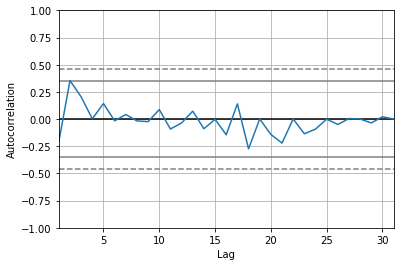

In [150]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
from pandas.plotting import autocorrelation_plot
# some counties: King (53033), NYC (36061), Chicago (17031), LA (6037), Wayne, MI (26163)
X, y = get_delta_deaths_ratio(36061, clip_zeros=True)
autocorrelation_plot(y)

In [143]:
pacf(y)

array([ 1.00000000e+00,  1.64055350e-01,  3.93356942e-01,  2.41438489e-01,
       -2.70335857e-01, -6.95294790e-04, -2.21043175e-01, -2.28864829e-01,
       -3.17872457e-01,  9.13002028e-02,  7.50289569e-02,  2.69626006e-01,
        8.29723665e-02, -1.89524271e-01, -2.16987839e-01, -4.86641357e-01,
       -7.92543789e-01, -1.89762432e+00,  1.11350386e+00,  5.09192395e+00,
       -1.16482952e+00, -1.04613574e-01,  5.30126709e-01,  5.42754056e-03,
        2.08767959e-01,  1.00016476e-01, -3.34823271e-01, -1.07394867e+00,
        2.88093221e+00,  1.27654432e+00, -5.65396943e-01,  2.56830464e+00,
        8.08354366e-01, -3.12102183e-01,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan])